In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [134]:
df_raw = pd.read_csv("hotel_bookings.csv")
df = df_raw.iloc[:3001]
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           3001 non-null   object 
 1   is_canceled                     3001 non-null   int64  
 2   lead_time                       3001 non-null   int64  
 3   arrival_date_year               3001 non-null   int64  
 4   arrival_date_month              3001 non-null   object 
 5   arrival_date_week_number        3001 non-null   int64  
 6   arrival_date_day_of_month       3001 non-null   int64  
 7   stays_in_weekend_nights         3001 non-null   int64  
 8   stays_in_week_nights            3001 non-null   int64  
 9   adults                          3001 non-null   int64  
 10  children                        3001 non-null   float64
 11  babies                          3001 non-null   int64  
 12  meal                            30

In [136]:
#karena company banyak null, maka di drop
df.drop(columns='company',inplace=True)

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [137]:
#karena ada satu yang nan, drop row yang memiliki country == nan
df.drop(index=df[df['country'].isna()==True].index, inplace=True)

In [138]:
#melihat bentuk data secara keseluruhan

for i in df.columns:
    print(i + ' with n unique ' + str(df[i].nunique()))

hotel with n unique 1
is_canceled with n unique 2
lead_time with n unique 229
arrival_date_year with n unique 1
arrival_date_month with n unique 5
arrival_date_week_number with n unique 20
arrival_date_day_of_month with n unique 31
stays_in_weekend_nights with n unique 10
stays_in_week_nights with n unique 18
adults with n unique 14
children with n unique 4
babies with n unique 3
meal with n unique 4
country with n unique 53
market_segment with n unique 6
distribution_channel with n unique 3
is_repeated_guest with n unique 1
previous_cancellations with n unique 1
previous_bookings_not_canceled with n unique 1
reserved_room_type with n unique 8
assigned_room_type with n unique 9
booking_changes with n unique 8
deposit_type with n unique 3
agent with n unique 66
days_in_waiting_list with n unique 3
customer_type with n unique 4
adr with n unique 1048
required_car_parking_spaces with n unique 3
total_of_special_requests with n unique 5
reservation_status with n unique 3
reservation_status

In [139]:
#menggabungkan kolom arrival date

def arrival_date(df):
    month = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
    for i,j in month.items():
        if df['arrival_date_month'] == i:
            a = str(df['arrival_date_year']) + '-' + j + '-' + str(df['arrival_date_day_of_month'])
            return a
        
df['arrival_date'] = df.apply(arrival_date, axis=1)

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [140]:
#mengubah format data menjadi format datetime

df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], yearfirst=True)
df['arrival_date'] = pd.to_datetime(df['arrival_date'], yearfirst=True)

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [141]:
# disini saya membuat kategori agent baru yaitu 0, dimana disini saya menganggap booking hotel dilakukan tanpa melalui agen

df['agent'].fillna(value=0, inplace=True)

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [142]:
df['stay_total'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 3000
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           3000 non-null   object        
 1   is_canceled                     3000 non-null   int64         
 2   lead_time                       3000 non-null   int64         
 3   arrival_date_year               3000 non-null   int64         
 4   arrival_date_month              3000 non-null   object        
 5   arrival_date_week_number        3000 non-null   int64         
 6   arrival_date_day_of_month       3000 non-null   int64         
 7   stays_in_weekend_nights         3000 non-null   int64         
 8   stays_in_week_nights            3000 non-null   int64         
 9   adults                          3000 non-null   int64         
 10  children                        3000 non-null   float64       
 11  babi

## EDA

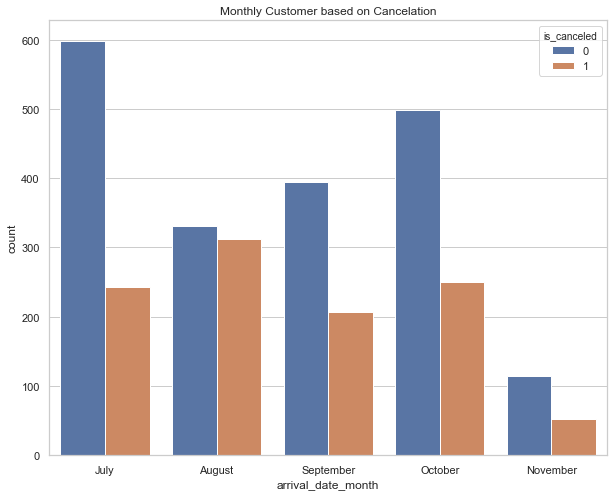

In [144]:
#disini saya mau melihat jumlah total customer yang canceled dan non_canceled tiap bulannya
#dilihat dari hasilnya, bulan agustus adalah bulan yg paling banyak 
#dicancel jika dibandingkan dengan total customer pada bulan itu (hampir 50-50)

plt.figure(figsize =(10,8))
plt.title("Monthly Customer based on Cancelation")
sns.countplot(data = df,x = "arrival_date_month", hue = 'is_canceled')

Text(0.5, 1.0, 'Customer Type vs Stay Total')

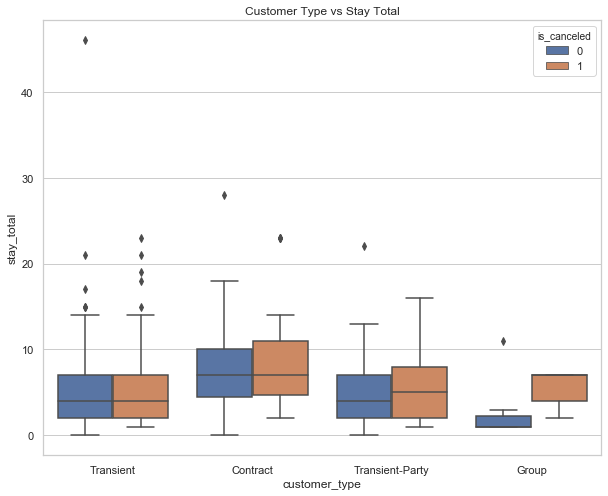

In [145]:
#disini saya melihat persebaran data berdasarkan tipe customer dan lama stay terhadap booking canceled atau tidak
#dari data ini dilihat bahwa customer tipe group dgn waktu stay yang lebih lama, cenderung cancel

plt.figure(figsize = (10,8))
sns.set(style='whitegrid')
sns.boxplot(x = "customer_type", y = "stay_total", data = df, hue = "is_canceled")
plt.title('Customer Type vs Stay Total')

In [146]:
df['adr_person'] = df['adr'] / (df['adults'] + df['children'])

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


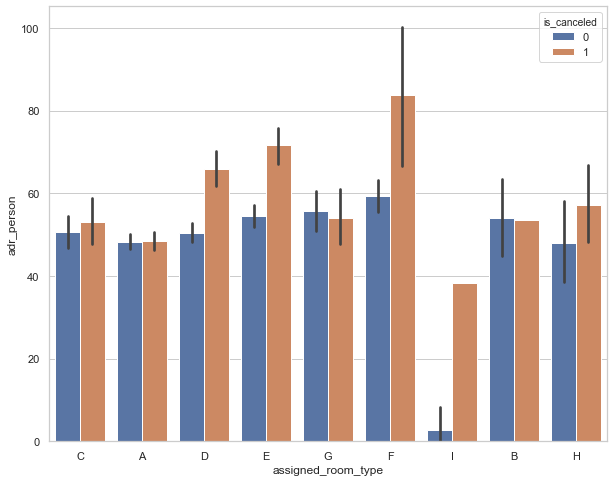

In [147]:
#disini saya plot harga room per person berdasarkan tipe room
#dari sini saya mengetahui bahwa kemungkinan room type I memiliki harga yang lebih murah dibanding room lain
#tetapi ketika customer mendapatkan room I dengan harga yang relatif mahal, maka akan cenderung dicancel oleh customer

plt.figure(figsize=(10,8))
sns.barplot(y='adr_person', x='assigned_room_type',hue='is_canceled', data=df)

In [148]:
def room_dif(df):
    if df['reserved_room_type'] == df['assigned_room_type']:
        return 'No'
    else:
        return 'Yes'

df['room_difference'] = df.apply(room_dif, axis=1)

C:\Users\Sony Vaio\anaconda3\envs\MyEnvironment\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


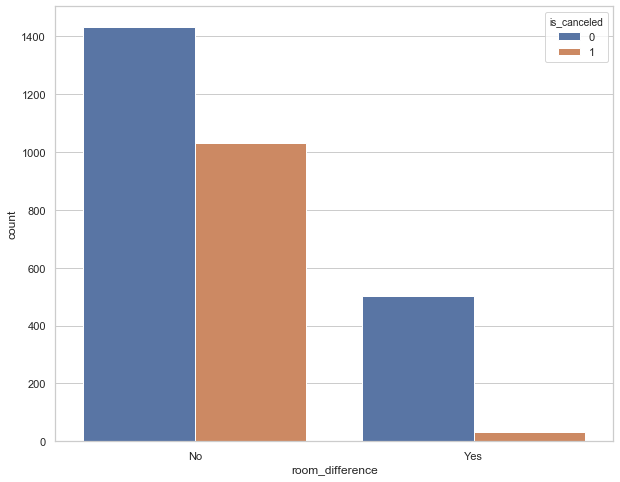

In [149]:
#disini saya mau melihat apakah kecenderungan customer untuk cancel berpengaruh terhadap perbedaan jumlah room yang didapatkan
#No = room sesuai yang di booking
#Yes = room berbeda dengan yang di booking

plt.figure(figsize=(10,8))
sns.countplot(data=df, x='room_difference',hue='is_canceled')

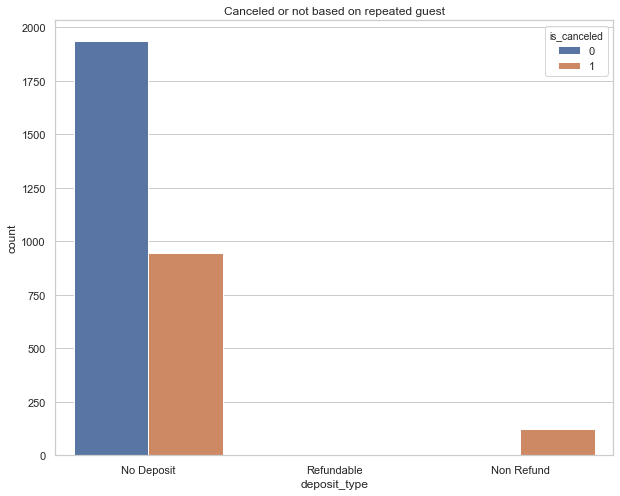

In [150]:
#disini saya melihat kecenderungan customer untuk cancel berdasarkan tipe deposit
#karena data yang digunakan tidak lengkap, maka data customer yang non refund dan refundable tidak tergambarkan

plt.figure(figsize=(10,8))
plt.title("Canceled or not based on repeated guest")
sns.countplot(data = df, x = "deposit_type", hue = 'is_canceled')

## Model Building and Hyperparameter Tuning

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 3000
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           3000 non-null   object        
 1   is_canceled                     3000 non-null   int64         
 2   lead_time                       3000 non-null   int64         
 3   arrival_date_year               3000 non-null   int64         
 4   arrival_date_month              3000 non-null   object        
 5   arrival_date_week_number        3000 non-null   int64         
 6   arrival_date_day_of_month       3000 non-null   int64         
 7   stays_in_weekend_nights         3000 non-null   int64         
 8   stays_in_week_nights            3000 non-null   int64         
 9   adults                          3000 non-null   int64         
 10  children                        3000 non-null   float64       
 11  babi

In [183]:
X = df.drop(columns=['hotel','is_canceled','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month',
                    'reserved_room_type','assigned_room_type','reservation_status','reservation_status_date','arrival_date'])
y = df.is_canceled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 24), (600, 24), (2400,), (600,))

In [188]:
X_train

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,stay_total,adr_person,room_difference
235,44,0,3,2,2.0,0,BB,PRT,Online TA,TA/TO,...,No Deposit,240.0,0,Transient,153.00,0,0,3,38.250,No
1627,47,2,4,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,...,No Deposit,8.0,0,Contract,79.50,0,0,6,39.750,No
1572,4,2,2,2,0.0,0,HB,PRT,Online TA,TA/TO,...,No Deposit,240.0,0,Transient,151.25,0,2,4,75.625,No
1767,120,2,3,2,0.0,0,BB,PRT,Online TA,TA/TO,...,No Deposit,240.0,0,Transient,107.00,0,2,5,53.500,No
2142,87,0,1,2,0.0,0,BB,PRT,Groups,TA/TO,...,Non Refund,96.0,0,Transient,36.05,0,0,1,18.025,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,2,0,1,1,0.0,0,BB,NLD,Online TA,TA/TO,...,No Deposit,240.0,0,Transient-Party,42.30,1,1,1,42.300,No
2079,48,2,5,2,0.0,0,BB,IRL,Offline TA/TO,TA/TO,...,No Deposit,171.0,0,Transient,52.73,0,0,7,26.365,No
2999,6,0,1,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,...,No Deposit,96.0,0,Transient,37.00,1,0,1,37.000,No
2885,1,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,...,No Deposit,0.0,0,Transient,35.00,0,0,1,35.000,No


In [213]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'stay_total']),
    ('categoric', cat_pipe(encoder='onehot'), ['meal','country','market_segment','distribution_channel','is_repeated_guest','deposit_type',
                                              'agent','customer_type','room_difference']),
])

data dibagi menjadi dua kategori yaitu numerical dan kategorikal. Data numerikal dimasukkan ke pipeline numerik dan di scaling menggunakan robust, sedangkan data kategorikal dilabel menggunakan one hot encoder

saya akan menggunakan 2 method, logistic regression dan random forest classification dengan hyper parameter tuning random search

In [237]:
from sklearn.linear_model import LogisticRegression
pipeline_logreg = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
model1 = RandomizedSearchCV(pipeline_logreg, gsp.logreg_params, cv=3, n_iter=3, n_jobs=-1, verbose=1, random_state=42)
model1.fit(X_train, y_train)

print(model1.best_params_)
print(model1.score(X_train, y_train), model1.best_score_, model1.score(X_test, y_test))

y_pred_logreg = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred_logreg, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.0s finished


{'algo__fit_intercept': False, 'algo__C': 100.0}
0.8770833333333333 0.8708333333333332 0.8833333333333333
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       371
           1       0.91      0.84      0.87       229

    accuracy                           0.91       600
   macro avg       0.91      0.89      0.90       600
weighted avg       0.91      0.91      0.91       600



In [238]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model2 = RandomizedSearchCV(pipeline_rf, gsp.rf_params, cv=3, n_iter=3, n_jobs=-1, verbose=1, random_state=42)
model2.fit(X_train, y_train)

print(model2.best_params_)
print(model2.score(X_train, y_train), model2.best_score_, model2.score(X_test, y_test))

y_pred_rf = model2.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred_rf, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.5s finished


{'algo__n_estimators': 100, 'algo__min_samples_leaf': 1, 'algo__max_features': 0.3, 'algo__max_depth': 20}
0.9870833333333333 0.8904166666666665 0.9016666666666666
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       370
           1       0.90      0.83      0.87       230

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.90      0.90       600



# Improve Model based on Benchmark Model

## Feature Importance Model LR

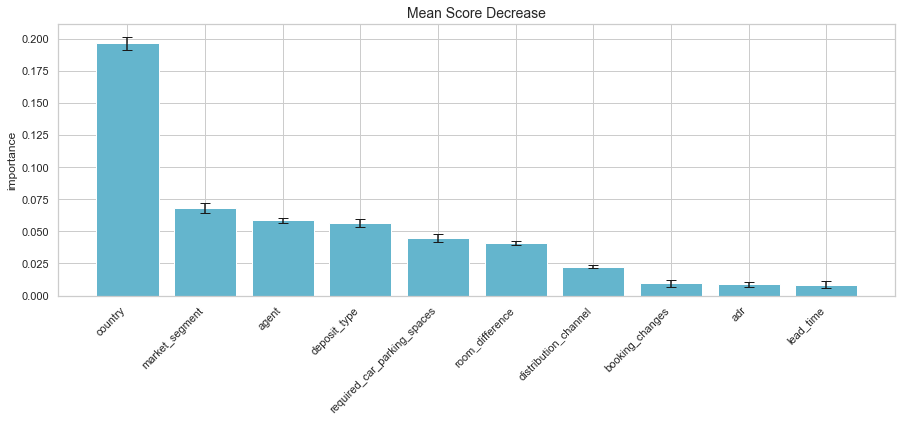

In [231]:
df_imp = mean_score_decrease(X_train, y_train, model1, plot=True, topk=10)

## Feature Importance Model RF

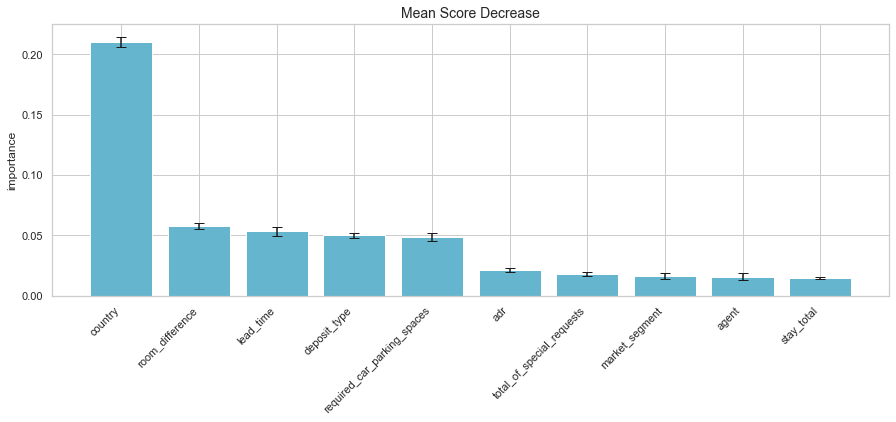

In [232]:
df_imp = mean_score_decrease(X_train, y_train, model2, plot=True, topk=10)

saya akan menggunakan feature importance pada model RF saja untuk melihat perubahan hasil model, saya menggunakan top 10 feature importance

In [242]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['lead_time',
        'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'stay_total']),
    ('categoric', cat_pipe(encoder='onehot'), ['country','market_segment','deposit_type',
                                              'agent','room_difference']),
])

In [240]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model2 = RandomizedSearchCV(pipeline_rf, gsp.rf_params, cv=3, n_iter=3, n_jobs=-1, verbose=1, random_state=42)
model2.fit(X_train, y_train)

print(model2.best_params_)
print(model2.score(X_train, y_train), model2.best_score_, model2.score(X_test, y_test))

y_pred_rf = model2.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred_rf, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.9s finished


{'algo__n_estimators': 100, 'algo__min_samples_leaf': 1, 'algo__max_features': 0.3, 'algo__max_depth': 20}
0.9870833333333333 0.8904166666666665 0.9016666666666666


## Kesimpulan

Dari hasil pemodelan, untuk predict 0 dan actuall 0 berarti itu True Negatif. Dan predict 1 actual 1 adalah True Positive.
Yang bahaya untuk perusahaan adalah mesin mempredik keduanya salah, dimana mesin prediksi cancel padahal tidak (hotel mengira customer cancel sehingga room diberikan ke orang lain) dan prediksi tidak cancel padahal cancel (orang lain tidak dapat room )